In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [72]:
import xarray as xa
import pandas as pd
import seaborn as sb
from corner import corner
from pytransit.orbits import epoch, fold
from pytransit.contamination.plotting import _jplot, joint_marginal_plot, plot_kdist, plot_two_sided_kde
from pytransit.utils.downsample import downsample_time_1d

from src.core import *

In [8]:
%run toi_2266.py

In [9]:
lpf = LPF('TOI-2266b-joint', downsample=None, m2_passbands=('r', 'i', 'z_s'))

In [10]:
with xa.load_dataset('TOI-2266.01-joint-contaminated-a.nc') as ds:
    fc = array(ds['mcmc_samples']).reshape([-1, ds.parameter.size])
    df = pd.DataFrame(fc, columns=ds.parameter)

In [31]:
pvp = permutation(df)[:500]

In [42]:
bl = median(lpf.baseline(pvp), 0)
fm = median(lpf.transit_model(pvp), 0)
tm = lpf.timea
fo = lpf.ofluxa / bl

In [43]:
epochs_all = array([epoch(t.mean(), pv[0], pv[1]) for t in lpf.times])
epochs_gb =  array([epochs_all[i] for i in range(len(epochs_all)) if lpf.pbids[i] != 0])

In [44]:
gbnights = unique(epochs_gb)
ngbnights = gbnights.size

In [45]:
eids = zeros_like(epochs_gb)
for i, e in enumerate(unique(epochs_gb)):
    eids[epochs_gb == e] = i

In [47]:
m2lcs = [lci for lci, ins in enumerate(lpf.ins) if ins=='M2']
m2eps = [epoch(lpf.times[i].mean(), pv[0], pv[1]) for i in m2lcs]
m2nights = unique(m2eps).size

In [49]:
hclcs = [lci for lci, ins in enumerate(lpf.ins) if ins=='HIP' or ins=='M2' or ins=='M3']
hceps = [epoch(lpf.times[i].mean(), pv[0], pv[1]) for i in hclcs]
hcnights = unique(hceps).size

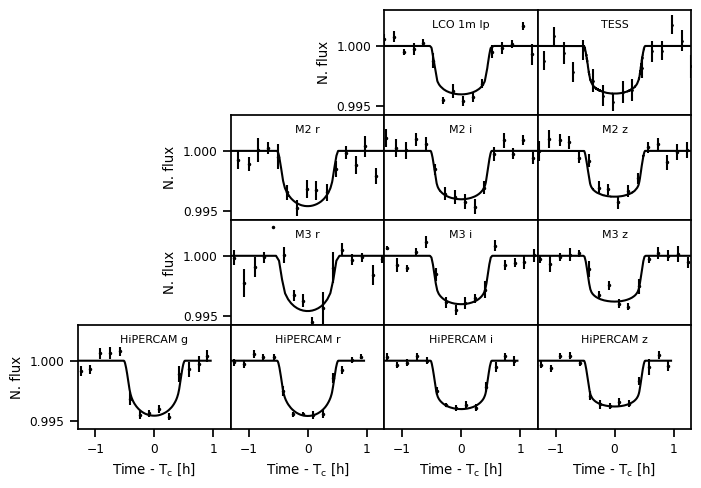

In [162]:
with sb.plotting_context('notebook', font_scale=0.8):
    fig = figure(figsize=(AAPW, 0.7*AAPW))
    axs = fig.subplot_mosaic(
    ['. . LCO1m TESS'.split(),
     '. M2r M2i M2z'.split(),
     '. M3r M3i M3z'.split(),
     'Hig Hir Hii Hiz'.split()], 
        #sharex=True, sharey=True, 
        gridspec_kw=dict(wspace=0, hspace=0))
    
    bw = 10
    
    # TESS
    phase = fold(tm[:lpf._ntess], pv[1], pv[0])
    fluxo = fo[:lpf._ntess]
    sids = argsort(phase)
    pb, fb, eb = downsample_time_1d(phase, fluxo, bw / 24 / 60, is_sorted=False)
    axs['TESS'].errorbar(24*pb, fb, eb, fmt='.k', ms=2)
    axs['TESS'].plot(24*phase[sids], fm[:lpf._ntess][sids], 'k')
    axs['TESS'].text(0.5, 0.9, 'TESS', transform=axs['TESS'].transAxes, va='top', ha='center', size='small')
    setp(axs['TESS'].get_yticklabels(), visible=False)
    setp(axs['TESS'].get_yticklines(), visible=False)
    
    # LCO 1m
    ixs = [i for i, ins in enumerate(lpf.ins) if ins=='LCO1m']
    times = concatenate([lpf.times[i] for i in ixs])
    phase = fold(times, pv[1], pv[0])
    sids = argsort(phase)
    fluxo = concatenate([fo[lpf.lcslices[i]] for i in ixs])
    fluxm = concatenate([fm[lpf.lcslices[i]] for i in ixs])
    pb, fb, eb = downsample_time_1d(phase, fluxo, bw / 24 / 60, is_sorted=False)
    axs['LCO1m'].errorbar(24*pb, fb, eb, fmt='.k', ms=3)
    axs['LCO1m'].plot(24*phase[sids], fluxm[sids], 'k')
    axs['LCO1m'].text(0.5, 0.9, 'LCO 1m Ip', transform=axs['LCO1m'].transAxes, va='top', ha='center', size='small')
    setp(axs['LCO1m'], ylabel='N. flux', yticks=[0.995, 1.0])

    # MuSCAT2
    for ipb,pb in enumerate('riz'):
        ax = axs[f'M2{pb}']
        if ipb == 0:
            setp(ax, ylabel='N. flux', yticks=[0.995, 1.0])
        else:
            setp(ax.get_yticklabels(), visible=False)
            setp(ax.get_yticklines(), visible=False)

        m2lcs = [lci for lci, ins in enumerate(lpf.ins) if ins=='M2' and lpf.pbids[lci]==ipb+2]
        m2eps = array([epoch(lpf.times[i].mean(), pv[0], pv[1]) for i in m2lcs])
        m2nights = unique(m2eps).size
        tcs = pv[0] + pv[1]*m2eps
        ntime = concatenate([lpf.times[i]-tcs[j] for j,i in enumerate(m2lcs)])
        nflux = concatenate([fo[lpf.lcslices[i]] for i in m2lcs])
        mflux = concatenate([fm[lpf.lcslices[i]] for i in m2lcs])
        sids = argsort(ntime)
        bt, bf, be = downsample_time_1d(ntime[sids], nflux[sids], bw / 60 / 24)    
        ax.errorbar(24*bt, bf, be, fmt='k.', ms=3)
        ax.plot(24*ntime[sids], mflux[sids], 'k')
        ax.text(0.5, 0.9, f'M2 {pb}', transform=ax.transAxes, va='top', ha='center', size='small')

    # MuSCAT3
    for ipb,pb in enumerate('riz'):
        ax = axs[f'M3{pb}']
        if ipb == 0:
            setp(ax, ylabel='N. flux', yticks=[0.995, 1.0])
        else:
            setp(ax.get_yticklabels(), visible=False)
            setp(ax.get_yticklines(), visible=False)
        m2lcs = [lci for lci, ins in enumerate(lpf.ins) if ins=='M3' and lpf.pbids[lci]==ipb+2]
        m2eps = array([epoch(lpf.times[i].mean(), pv[0], pv[1]) for i in m2lcs])
        m2nights = unique(m2eps).size
        tcs = pv[0] + pv[1]*m2eps
        ntime = concatenate([lpf.times[i]-tcs[j] for j,i in enumerate(m2lcs)])
        nflux = concatenate([fo[lpf.lcslices[i]] for i in m2lcs])
        mflux = concatenate([fm[lpf.lcslices[i]] for i in m2lcs])
        sids = argsort(ntime)
        bt, bf, be = downsample_time_1d(ntime[sids], nflux[sids], bw / 60 / 24)    
        axs[f'M3{pb}'].errorbar(24*bt, bf, be, fmt='k.', ms=3)
        axs[f'M3{pb}'].plot(24*ntime[sids], mflux[sids], 'k')
        ax.text(0.5, 0.9, f'M3 {pb}', transform=ax.transAxes, va='top', ha='center', size='small')

    # HiPERCAM
    istart = lpf.ins.index('HIP')
    for ipb,pb in enumerate('griz'):
        ax = axs[f'Hi{pb}']
        if ipb == 0:
            setp(ax, ylabel='N. flux', yticks=[0.995, 1.0])
        else:
            setp(ax.get_yticklabels(), visible=False)
            setp(ax.get_yticklines(), visible=False)
        sl = lpf.lcslices[istart+ipb]
        phase = fold(lpf.timea[sl], pv[1], pv[0])
        sids = argsort(phase)
        bt, bf, be = downsample_time_1d(phase, fo[sl], bw / 60 / 24)    
        axs[f'Hi{pb}'].errorbar(24*bt, bf, be, fmt='k.', ms=3)
        axs[f'Hi{pb}'].plot(24*phase, fm[sl], 'k')
        ax.text(0.5, 0.9, f'HiPERCAM {pb}', transform=ax.transAxes, va='top', ha='center', size='small')

    
    setp(fig.axes, xlim=(-1.3, 1.3), ylim=(0.9943, 1.003))
    setp(fig.axes[-4:], xlabel='Time - T$_\mathrm{c}$ [h]')

    fig.tight_layout()
    fig.savefig('plots/multicolour_light_curves.pdf')